# Smaller dataset creation logic
During the EDA we saw that there are loads of images in each sample.  
For fast iteration it's not possible to use them all for training  
To speed up experimentation we'll only use some images from `kidney_1_dense` sample for trainig, validation, and testing. 
In the EDA notebook we also saw that the images that are next to each other are very similar since they're coming one after the other in the 3D slice, so that won't bring much of a new information for the model to learn.  
On the other hand, if we take images randomly, it might be that the training image coincides or really close to the val/test one and hence resulting in a leak and skewing validation results.  
To avoid this situation we'll take every 10th image from the first thousand ending up with 100 images for training.
And then every 20th image from the next 1000 images and split them into validation and test set resulting in 25 images for each.

## Create directories to store the images and labels

In [1]:
!mkdir -p ../dataset/train/images
!mkdir -p ../dataset/train/labels
!mkdir -p ../dataset/val/images
!mkdir -p ../dataset/val/labels
!mkdir -p ../dataset/test/images
!mkdir -p ../dataset/test/labels

In [2]:
GCS_PATH = "gs://kds-435748dc60032c71c8c8d636b553f125b1f40cdc3e86846628773d16"

## Copy the files from GCS to local redistributing them according to the described strategy

In [3]:
!gsutil -m cp -n '{GCS_PATH}/train/kidney_1_dense/images/0??5.tif' ../dataset/train/images
!gsutil -m cp -n '{GCS_PATH}/train/kidney_1_dense/labels/0??5.tif' ../dataset/train/labels

!gsutil -m cp -n '{GCS_PATH}/train/kidney_1_dense/images/1[0-4][0,2,4,6,8]5.tif' ../dataset/val/images
!gsutil -m cp -n '{GCS_PATH}/train/kidney_1_dense/labels/1[0-4][0,2,4,6,8]5.tif' ../dataset/val/labels

!gsutil -m cp -n '{GCS_PATH}/train/kidney_1_dense/images/1[5-9][0,2,4,6,8]5.tif' ../dataset/test/images
!gsutil -m cp -n '{GCS_PATH}/train/kidney_1_dense/labels/1[5-9][0,2,4,6,8]5.tif' ../dataset/test/labels

If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying gs://kds-435748dc60032c71c8c8d636b553f125b1f40cdc3e86846628773d16/train/kidney_1_dense/images/0005.tif...
Copying gs://kds-435748dc60032c71c8c8d636b553f125b1f40cdc3e86846628773d16/train/kidney_1_dense/images/0015.tif...
Copying gs://kds-435748dc60032c71c8c8d636b553f125b1f40cdc3e86846628773d16/train/kidney_1_dense/images/0025.tif...
Copying gs://kds-435748dc60032c71c8c8d636b553f125b1f40cdc3e86846628773d16/train/kidney_1_dense/images/0035.tif...
Copying gs://kds-435748dc60032c71c8c8d636b553f125b1f40cdc3e86846628773d16/train/kidney_1_dense/images/0045.tif...
Copying gs://kds-435748dc60032c71c8c8d636b553f125b1f40cdc3e86846628773d16/train

### Sanity check

In [4]:
!ls ../dataset/train/images | wc -l
!ls ../dataset/train/labels | wc -l
!ls ../dataset/val/images | wc -l
!ls ../dataset/val/labels | wc -l
!ls ../dataset/test/images | wc -l
!ls ../dataset/test/labels | wc -l

     100
     100
      25
      25
      25
      25


**Note**:
if the result of the previos cell is not
```
     100
     100
      25
      25
      25
      25
```

re-run the cell that downloads the data from GCS, it will download what's left not re-writing existing images

# Modify labels to get YOLOv8 accepted format

The plan is to finetune yolov8 segmentation model.  
Unfortunately, it doesn't accept binary image masks, instead it needs masks as polygons in txt format.
Below we will convert the masks from provided `.tif` format to yolo-required `.txt` format

The conversion is the following

binary image masks => COCO format => YOLO format

## binary image masks => COCO format
Based on [this code](https://github.com/bnsreenu/python_for_microscopists/blob/master/332%20-%20All%20about%20image%20annotations%E2%80%8B/binary_to_coco_V3.0.py) that was slightly adjusted

YT video with explanation: https://www.youtube.com/watch?v=NYeJvxe5nYw

# COCO format => YOLO format

Done with the help of `ultralytics.data.converter.convert_coco`

In [5]:
from yolo_conversion_utils import process_masks

In [6]:
process_masks('../dataset/train/', '../dataset/train/train.json')
process_masks('../dataset/val/', '../dataset/val/val.json')
process_masks('../dataset/test/', '../dataset/test/test.json')

Created 8984 annotations for images in folder: ../dataset/train/
Created 2699 annotations for images in folder: ../dataset/val/
Created 2243 annotations for images in folder: ../dataset/test/


Remove tif labels

In [7]:
!rm ../dataset/train/labels/*.tif
!rm ../dataset/val/labels/*.tif
!rm ../dataset/test/labels/*.tif

Convert annotations from coco json to yolo format using ultralytics

In [8]:
from ultralytics.data.converter import convert_coco

In [9]:
convert_coco(labels_dir='../dataset/train', 
             use_segments=True,
             cls91to80=False,)

Annotations /Users/alexlitvinov/Documents/projects/hacking_human_vasculature/dataset/train/train.json: 100%|██████████| 95/95 [00:01<00:00,

COCO data converted successfully.
Results saved to /Users/alexlitvinov/Documents/projects/hacking_human_vasculature/notebooks/coco_converted


In [10]:
!cp  coco_converted/labels/train/*.txt ../dataset/train/labels
!rm -r coco_converted

In [11]:
convert_coco(labels_dir='../dataset/val', 
             use_segments=True,
             cls91to80=False,)

Annotations /Users/alexlitvinov/Documents/projects/hacking_human_vasculature/dataset/val/val.json: 100%|██████████| 25/25 [00:00<00:00, 33.

COCO data converted successfully.
Results saved to /Users/alexlitvinov/Documents/projects/hacking_human_vasculature/notebooks/coco_converted


In [12]:
!cp  coco_converted/labels/val/*.txt ../dataset/val/labels
!rm -r coco_converted

In [13]:
convert_coco(labels_dir='../dataset/test', 
             use_segments=True,
             cls91to80=False,)

Annotations /Users/alexlitvinov/Documents/projects/hacking_human_vasculature/dataset/test/test.json: 100%|██████████| 25/25 [00:00<00:00, 9

COCO data converted successfully.
Results saved to /Users/alexlitvinov/Documents/projects/hacking_human_vasculature/notebooks/coco_converted


In [14]:
!cp  coco_converted/labels/test/*.txt ../dataset/test/labels
!rm -r coco_converted

# Visualize the masks to ensure correct conversion

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import cv2

def display_image_with_annotations(image_path, annotation_path, colors=None):
    # Load image using OpenCV and convert it from BGR to RGB color space
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape
    # Create a figure and axis to display the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.axis('off')  # Turn off the axes

    # Define a default color map if none is provided
    if colors is None:
        colors = matplotlib.colormaps['tab10']

    # Open the annotation file and process each line
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            category_id = int(parts[0])
            # Choose color based on category ID, looping through color map if more than 10 categories
            color = colors(category_id % 10)
            # Extract normalized polygon coordinates and denormalize them
            polygon = [float(coord) for coord in parts[1:]]
            polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
            # Reshape into (num_points, 2) array
            polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
            # Create a Polygon patch using the denormalized coordinates
            patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
            # Add the patch to the plot to display the annotated region
            ax.add_patch(patch)

    plt.show()

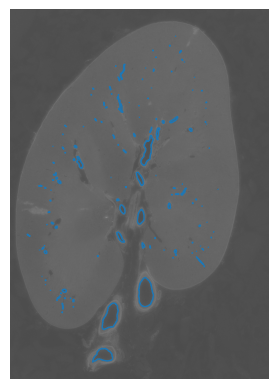

In [16]:
image_path = "../dataset/train/images/0995.tif"
annotation_path = "../dataset/train/labels/0995.txt"
display_image_with_annotations(image_path, annotation_path)

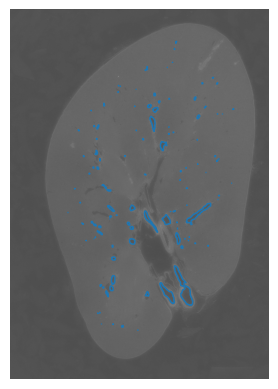

In [17]:
image_path = "../dataset/val/images/1445.tif"
annotation_path = "../dataset/val/labels/1445.txt"
display_image_with_annotations(image_path, annotation_path)

Looking good!